<a href="https://colab.research.google.com/github/RonakArora09/Image-Segmentation-U_Net/blob/main/Image_Segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/CamVid.zip -d /tmp/

Archive:  /content/drive/MyDrive/CamVid.zip
  inflating: /tmp/CamVid/class_dict.csv  
  inflating: /tmp/CamVid/test/0001TP_006690.png  
  inflating: /tmp/CamVid/test/0001TP_006720.png  
  inflating: /tmp/CamVid/test/0001TP_006750.png  
  inflating: /tmp/CamVid/test/0001TP_006780.png  
  inflating: /tmp/CamVid/test/0001TP_006810.png  
  inflating: /tmp/CamVid/test/0001TP_006840.png  
  inflating: /tmp/CamVid/test/0001TP_006870.png  
  inflating: /tmp/CamVid/test/0001TP_006900.png  
  inflating: /tmp/CamVid/test/0001TP_006930.png  
  inflating: /tmp/CamVid/test/0001TP_006960.png  
  inflating: /tmp/CamVid/test/0001TP_006990.png  
  inflating: /tmp/CamVid/test/0001TP_007020.png  
  inflating: /tmp/CamVid/test/0001TP_007050.png  
  inflating: /tmp/CamVid/test/0001TP_007080.png  
  inflating: /tmp/CamVid/test/0001TP_007110.png  
  inflating: /tmp/CamVid/test/0001TP_007140.png  
  inflating: /tmp/CamVid/test/0001TP_007170.png  
  inflating: /tmp/CamVid/test/0001TP_007200.png  
  inflating: /

In [21]:
train_df = {"img" : [], "mask" : []}
val_df   = {"img" : [], "mask" : []}
test_df  = {"img" : [], "mask" : []}

In [4]:
def load_data(data_frame, img_path, mask_path, shape = 256):

    images_fname = os.listdir(img_path)
    masks_fname = []

    for fname in images_fname:
        masks_fname.append(fname[:-(len('.png'))] + '_L.png')

    for i in range(len(images_fname)):
        image = plt.imread(img_path + images_fname[i])
        mask  = plt.imread(mask_path + masks_fname[i])

        image = cv2.resize(image, (shape, shape))
        mask  = cv2.resize(mask, (shape, shape))

        data_frame['img'].append(image)
        data_frame['mask'].append(mask)

In [22]:
load_data(train_df, '/tmp/CamVid/train/', '/tmp/CamVid/train_labels/')
load_data(val_df, '/tmp/CamVid/val/', '/tmp/CamVid/val_labels/')
load_data(test_df, '/tmp/CamVid/test/', '/tmp/CamVid/test_labels/')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


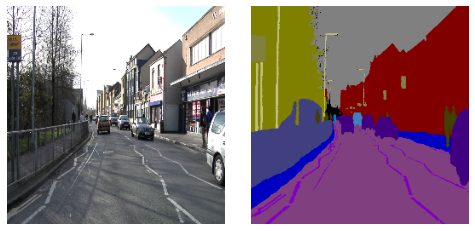

In [6]:
fig = plt.figure(figsize=(16,4))
plt.axis("off")

sub = fig.add_subplot(1, 1, 1)
sub.axis("off")
sub.imshow(train_df['img'][0])

sub = fig.add_subplot(1, 2, 2)
sub.axis("off")
sub.imshow(train_df['mask'][0])
plt.show()

In [7]:
class Conv2D_Block(keras.layers.Layer):

    def __init__(self, num_filters, kernel_size = (3,3), **kwargs):
        super(Conv2D_Block, self).__init__(**kwargs)

        self.conv2D_1 = keras.layers.Conv2D(num_filters, kernel_size = kernel_size, padding = 'same', activation ='relu')
        self.norm_1   = keras.layers.BatchNormalization()

        self.conv2d_2 = keras.layers.Conv2D(num_filters, kernel_size = kernel_size, padding = 'same', activation = 'relu')
        self.norm_2   = keras.layers.BatchNormalization()

    def call(self, X):
        Z = self.conv2D_1(X)
        Z = self.norm_1(Z)
        Z = self.conv2d_2(Z)
        Z = self.norm_2(Z)

        return Z

In [8]:
class Encoder_Block(keras.layers.Layer):
    def __init__(self, num_filters, kernel_size = (3,3), dropout = 0.2, **kwargs):
        super(Encoder_Block, self).__init__(**kwargs)

        self.conv2D   = Conv2D_Block(num_filters, kernel_size)
        self.maxPool  = keras.layers.MaxPool2D(strides = 2)
        self.dropout  = keras.layers.Dropout(dropout)

    def call(self, X):
        C = self.conv2D(X)
        Z = self.maxPool(C)
        Z = self.dropout(Z)

        return C, Z

In [9]:
class Decoder_Block(keras.layers.Layer):
    def __init__(self, num_filters, kernel_size = (3,3), dropout = 0.2, **kwargs):
        super(Decoder_Block, self).__init__(**kwargs)

        self.conv2D_transpose = keras.layers.Conv2DTranspose(8*num_filters, kernel_size=kernel_size, strides=(2,2), padding="same")
        self.concatenate      = keras.layers.Concatenate()
        self.dropout          = keras.layers.Dropout(dropout)
        self.conv2D           = Conv2D_Block(num_filters, kernel_size)

    def call(self, X):
        C = X[0]
        Z = X[1]
        Z = self.conv2D_transpose(Z)
        Z = self.concatenate([C, Z])
        Z = self.dropout(Z)
        Z = self.conv2D(Z)

        return Z

In [10]:
class U_Net(keras.Model):

    def __init__(self, num_filters = 16, **kwargs):
        super(U_Net, self).__init__(**kwargs)

        ## encoder block

        self.block1 = Encoder_Block(1*num_filters)
        self.block2 = Encoder_Block(2*num_filters)
        self.block3 = Encoder_Block(4*num_filters)
        self.block4 = Encoder_Block(8*num_filters)
        self.block5 = Conv2D_Block(16*num_filters)

        ## decoder block

        self.block6 = Decoder_Block(8*num_filters)
        self.block7 = Decoder_Block(4*num_filters)
        self.block8 = Decoder_Block(2*num_filters)
        self.block9 = Decoder_Block(1*num_filters)

        self.out    = keras.layers.Conv2D(3, kernel_size = (1,1), activation = tf.nn.sigmoid)

    def call(self, input):

        C1, Z = self.block1(input)
        C2, Z = self.block2(Z)
        C3, Z = self.block3(Z)
        C4, Z = self.block4(Z)
        Z     = self.block5(Z)

        Z     = self.block6([C4, Z])
        Z     = self.block7([C3, Z])
        Z     = self.block8([C2, Z])
        Z     = self.block9([C1, Z])

        output = self.out(Z)

        return output

In [23]:
model = U_Net()

In [24]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [25]:
model.build(input_shape = (None, 256, 256, 3))

In [27]:
model.fit(np.array(train_df['img']), np.array(train_df['mask']), validation_data=(np.array(val_df['img']), np.array(val_df['mask'])), epochs = 100)

Epoch 1/100
12/12 [==============================] - 15s 1s/step - loss: 0.6830 - accuracy: 0.3373 - val_loss: 0.7411 - val_accuracy: 0.8087
Epoch 2/100
12/12 [==============================] - 13s 1s/step - loss: 0.6389 - accuracy: 0.3796 - val_loss: 0.8266 - val_accuracy: 0.7829
Epoch 3/100
12/12 [==============================] - 14s 1s/step - loss: 0.6212 - accuracy: 0.3851 - val_loss: 0.7533 - val_accuracy: 0.7556
Epoch 4/100
12/12 [==============================] - 14s 1s/step - loss: 0.6100 - accuracy: 0.3822 - val_loss: 0.7170 - val_accuracy: 0.3224
Epoch 5/100
12/12 [==============================] - 14s 1s/step - loss: 0.6014 - accuracy: 0.4015 - val_loss: 0.7074 - val_accuracy: 0.1972
Epoch 6/100
12/12 [==============================] - 14s 1s/step - loss: 0.5938 - accuracy: 0.3986 - val_loss: 0.6902 - val_accuracy: 0.1666
Epoch 7/100
12/12 [==============================] - 14s 1s/step - loss: 0.5870 - accuracy: 0.4093 - val_loss: 0.6848 - val_accuracy: 0.1515
Epoch 8/100
1

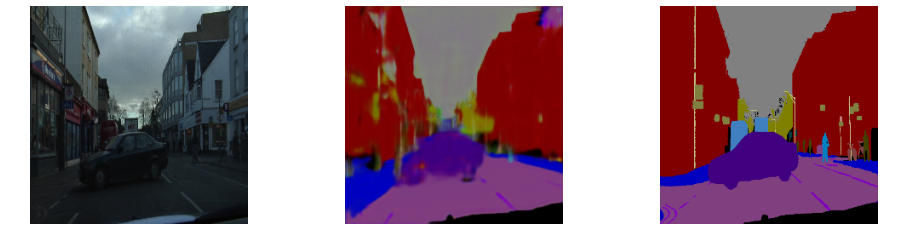

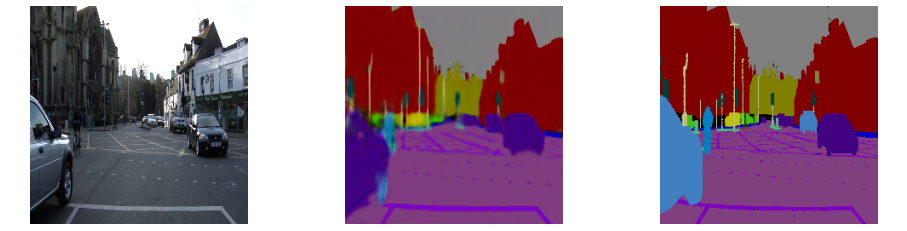

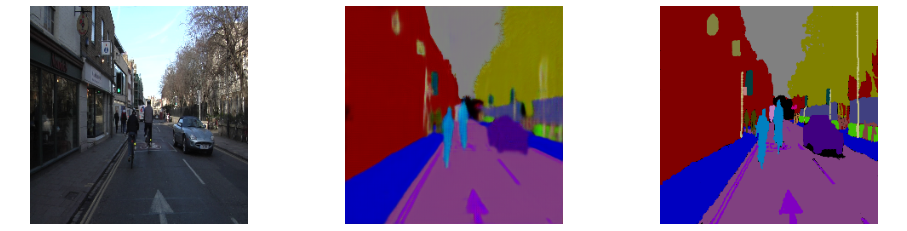

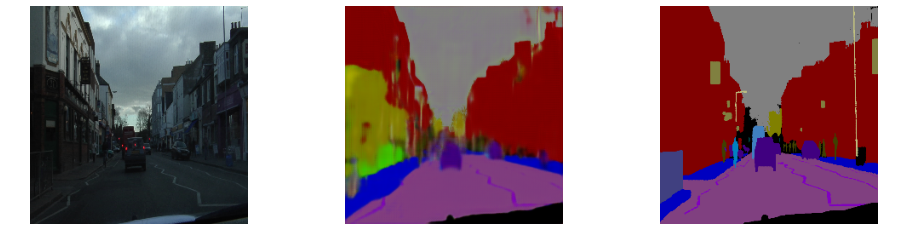

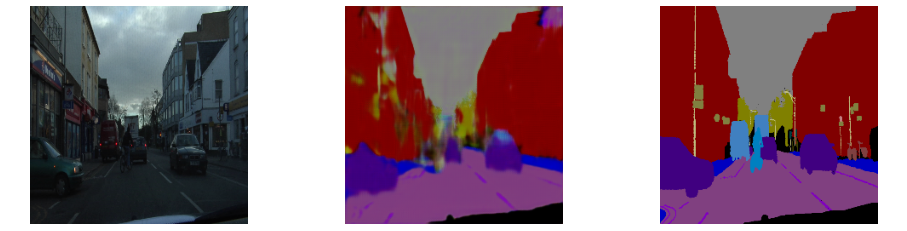

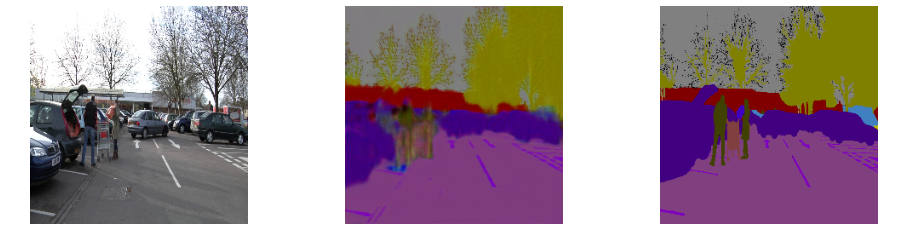

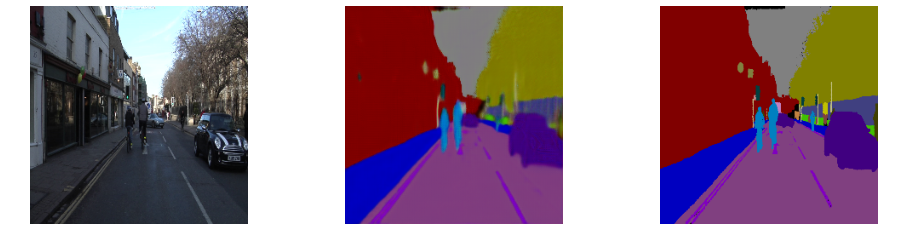

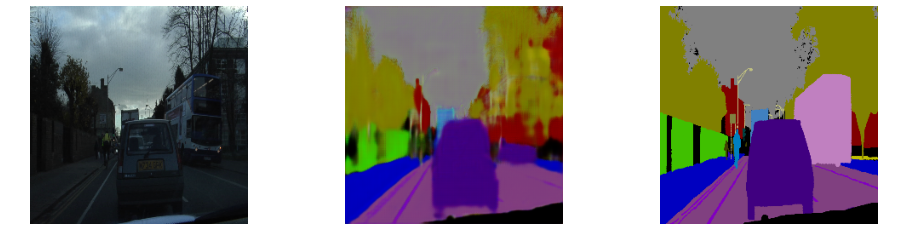

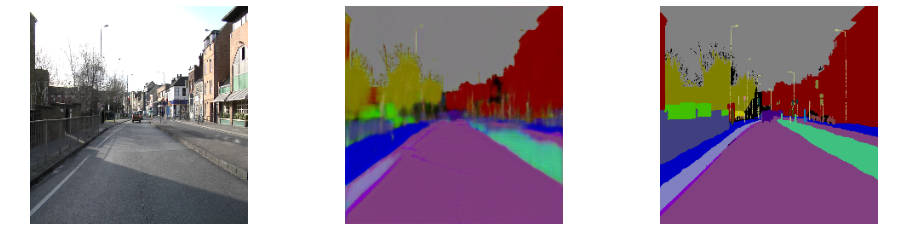

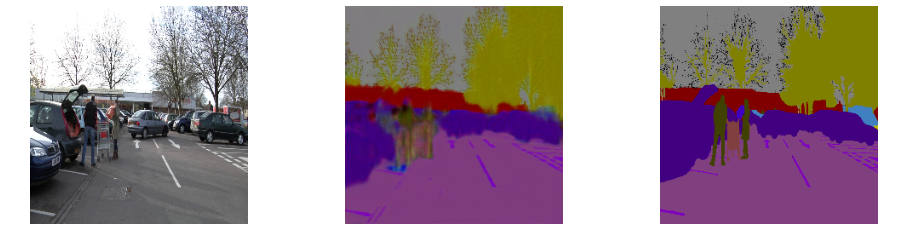

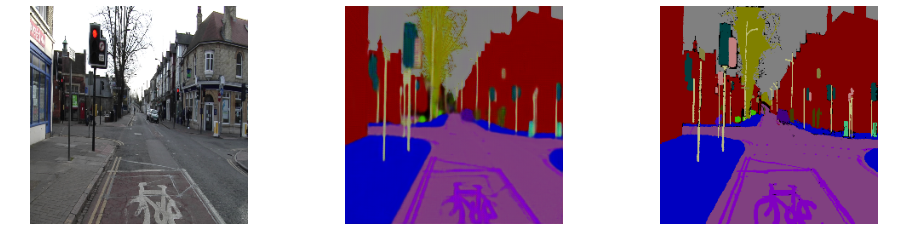

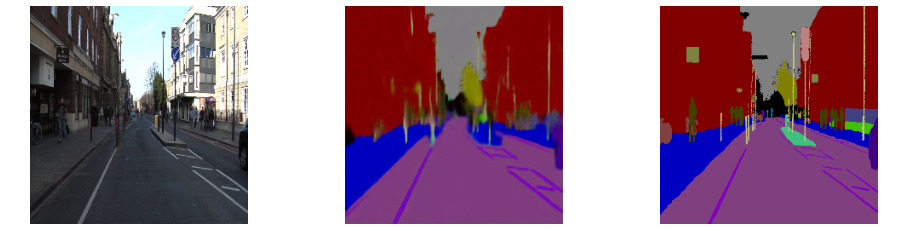

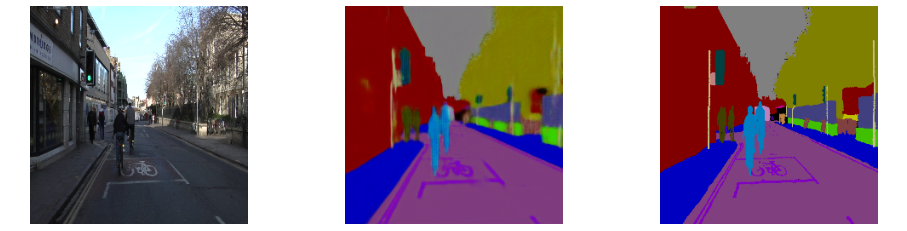

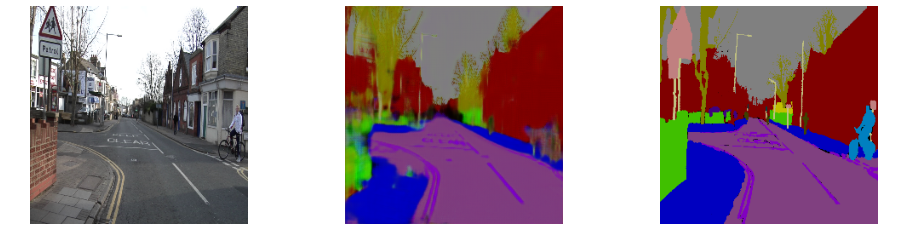

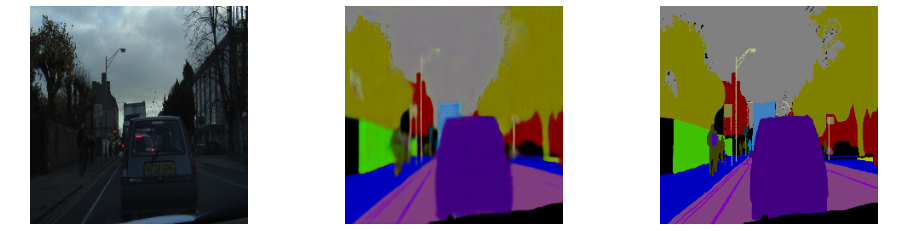

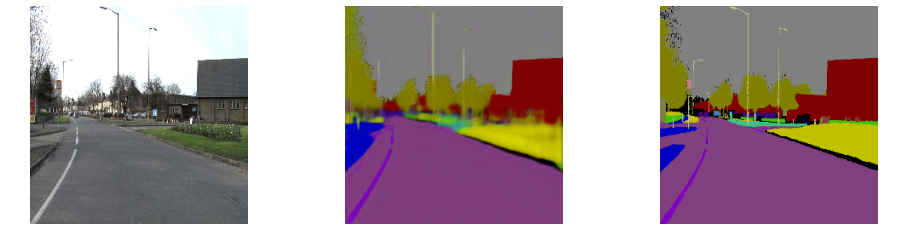

In [30]:
mask_pred = model.predict(np.array(test_df['img']))
random_nos = np.random.randint(low = 0,high = len(test_df['img']), size = 16)
for i in random_nos:
    fig = plt.figure(figsize=(16,4))
    plt.axis("off")

    sub = fig.add_subplot(1, 3, 1)
    sub.axis("off")
    sub.imshow(test_df['img'][i])

    sub = fig.add_subplot(1, 3, 2)
    sub.axis("off")
    sub.imshow(mask_pred[i])

    sub = fig.add_subplot(1, 3, 3)
    sub.axis("off")
    sub.imshow(test_df['mask'][i])
    plt.show()